# preparation

In [1]:
!pip install deep_phonemizer

  Preparing metadata (setup.py) ... done
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.19-py3-none-any.whl size=33273 sha256=bc77a25adaf64cc8a830886b0ca531ebba8f905047ff2610e9ee673854d27976
  Stored in directory: /root/.cache/pip/wheels/c7/61/da/39b050eea5710fe32b1521b79de4a74d95896581230d30a37b
Successfully built deep_phonemizer


In [2]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.5.0+cu121
2.5.0+cu121
cuda


In [3]:
import IPython
import matplotlib.pyplot as plt

# text processing

## Character-based encoding

In [4]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s:i for i,s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):

    text = text.lower()

    return [look_up[s] for s in text if s in symbols]

text = "Hello world! Text to speech!"
print(text_to_sequence(text))



[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [6]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello world! Text to speech!"
processed,lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


In [7]:
print([processor.tokens[i] for i in processed[0,:lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


## Phoneme-based encoding

In [8]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():

    processed,lengths = processor(text)

print(processed)
print(lengths)

100%|██████████| 63.6M/63.6M [00:03<00:00, 16.7MB/s]
/usr/local/lib/python3.10/dist-packages/dp/model/model.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint 

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [9]:
print([processor.tokens[i] for i in processed[0,:lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


# Spectrogram Generation

/usr/local/lib/python3.10/dist-packages/dp/model/model.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/u

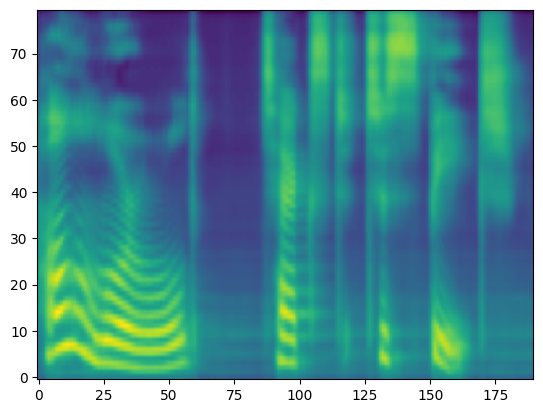

In [10]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():

    processed,lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec,_,_ = tacotron2.infer(processed,lengths)

_ = plt.imshow(spec[0].cpu().detach(),origin = "lower", aspect = "auto")

torch.Size([80, 191])
torch.Size([80, 171])
torch.Size([80, 182])


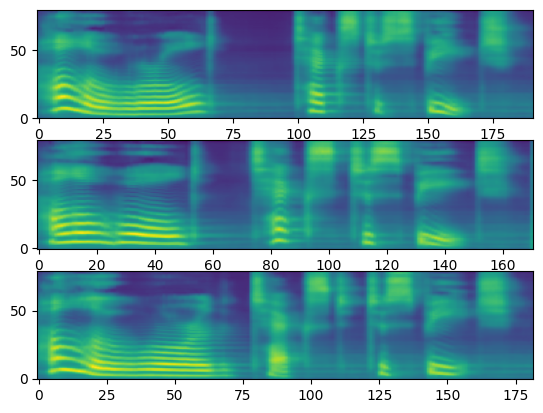

In [11]:
def plot():

    fig, ax = plt.subplots(3,1)

    for i in range(3):

        with torch.inference_mode():

            spec,spec_lengths,_ = tacotron2.infer(processed,lengths)

        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin = "lower", aspect = "auto")

plot()

# Waveform Generation

## WaveRNN Vocoder

In [12]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():

    processed,lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec,spec_lengths,_ = tacotron2.infer(processed,lengths)
    waveforms,lengths = vocoder(spec,spec_lengths)

/usr/local/lib/python3.10/dist-packages/dp/model/model.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/u

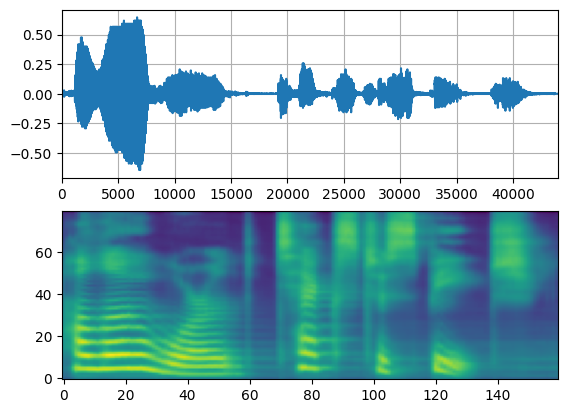

In [13]:
def plot(waveforms, spec, sample_rate):

    waveforms = waveforms.cpu().detach()

    fig, [ax1,ax2] = plt.subplots(2,1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0,waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin = "lower", aspect="auto")

    return IPython.display.Audio(waveforms[0:1], rate = sample_rate)

plot(waveforms,spec, vocoder.sample_rate)

## Griffin-Lim Vocoder

In [14]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():

    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths,_ = tacotron2.infer(processed, lengths)

waveforms, lengths = vocoder(spec, spec_lengths)

/usr/local/lib/python3.10/dist-packages/dp/model/model.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/u

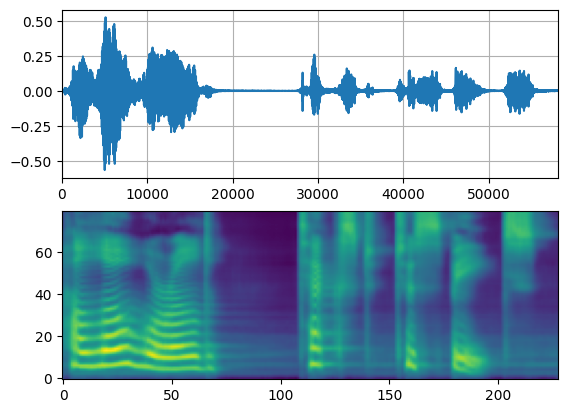

In [15]:
plot(waveforms, spec, vocoder.sample_rate)

## Waveglow Vocoder

In [17]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained = False,
)

checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",
    progress = False,
    map_location = device,
)

state_dict = {key.replace("module.",""): value for key, value in checkpoint['state_dict'].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():

    waveforms = waveglow.infer(spec)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


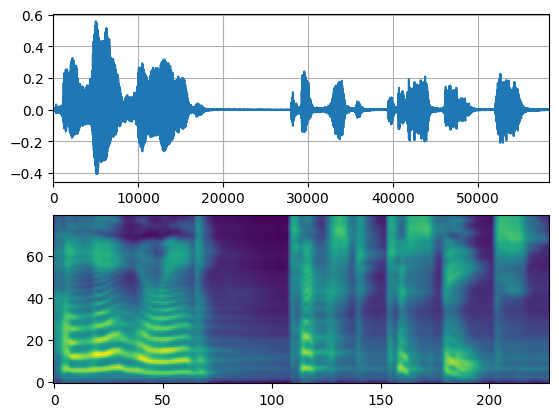

In [18]:
plot(waveforms, spec, 22050)